In [53]:
#import libraries
import sys
import os
import numpy as np
import pandas as pd

from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from xgboost import XGBClassifier
#import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.multiclass import type_of_target
from math import sqrt

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import seaborn as sns

sys.path.append('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone')

from utils.helpers import fit_model_get_predictions, objective, plot_feature_importances

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None) 

In [55]:
# Load data
df = pd.read_csv('/Users/bethbarlow/Documents/Nanodegree/udacity_ds_nanodegree_capstone/data/data_preproc.csv')

# Remove unnamed columns
df.drop(columns = 'Unnamed: 0', inplace = True)

In [46]:
# Apply label encoding to categorical variables  

le = preprocessing.LabelEncoder()
le.fit(df.Sector)
df.Sector = le.transform(df.Sector) # encode sector
le.fit(df.Rating)
df.Rating = le.transform(df.Rating) # encode rating
le.fit(df['Rating Agency Name'])
df['Rating Agency Name'] = le.transform(df['Rating Agency Name']) # encode rating agency name

In [47]:
# Define target and response variables
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

Class=0, n=398 (19.645%)
Class=4, n=670 (33.070%)
Class=1, n=94 (4.640%)
Class=3, n=490 (24.186%)
Class=2, n=302 (14.906%)
Class=5, n=72 (3.554%)


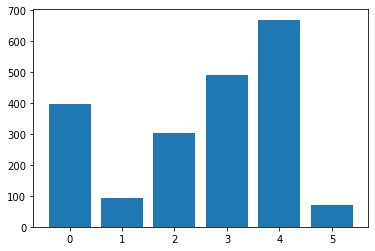

In [56]:
# Summarize distribution to check for imbalance
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    
# Plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [57]:
# Define numerical and categorical columns
numerical_ix = df.iloc[:, 3:23].columns.tolist()
categorical_ix = ['Rating Agency Name', 'Sector']

# One-hot encoding of categorical variables
encoder = OneHotEncoder(handle_unknown = 'ignore')
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_ix]).toarray())
X_encoded.columns = encoder.get_feature_names_out(categorical_ix)
X = X.join(X_encoded)
X.drop(columns = categorical_ix, axis = 1, inplace = True)

KeyError: "None of [Index(['Rating Agency Name', 'Sector'], dtype='object')] are in the [columns]"

In [52]:
# Define train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5)

# Scale numerical features
scaler = MinMaxScaler()
X_train[numerical_ix] = scaler.fit_transform(X_train[numerical_ix]) # check - do you scale cyclical variables?
X_test[numerical_ix] = scaler.transform(X_test[numerical_ix])

# Split train set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/5)

X_train.shape, X_val.shape, X_test.shape

### Fit Models

In [23]:
# Define features list
features = X.columns.tolist()

In [24]:
# Fit multinomial logistic regression model
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000)

lr_results = fit_model_get_predictions(lr, features)
lr_results

{'classifier': LogisticRegression(max_iter=1000, multi_class='multinomial'),
 'train_f1': 0.3860024038682445,
 'val_f1': 0.3731148276656803,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [30]:
# Fit Random Forest model
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf_results = fit_model_get_predictions(rf, features)
rf_results

{'classifier': RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42),
 'train_f1': 0.9907456818806734,
 'val_f1': 0.4908545381786499,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [31]:
# Fit K Nearest Neighbours model
knn = KNeighborsClassifier()
knn_results = fit_model_get_predictions(knn, features)
knn_results

{'classifier': KNeighborsClassifier(),
 'train_f1': 0.5242042809817,
 'val_f1': 0.3847901087590057,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [32]:
# Fit Naive Bayes model
gnb = GaussianNB()

gnb_results = fit_model_get_predictions(gnb, features)
gnb_results

{'classifier': GaussianNB(),
 'train_f1': 0.13448809908475834,
 'val_f1': 0.09599853877084695,
 'training_execution_time': 0.0,
 'prediction_execution_time': 0.0}

In [33]:
# Fit XGBoost model 
xgb = XGBClassifier()
xgb_results = fit_model_get_predictions(xgb, features)
xgb_results

{'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='multi:softprob', predictor=None, ...),
 'train_f1': 1.0,
 'val_f1': 0.5543219885379586,
 'training_execution_time': 3.0,
 'prediction_execution_time': 0.0}

In [34]:
# Get f1 scores from each fitted model and plot
val_f1_list = [lr_results['val_f1'], rf_results['val_f1'], knn_results['val_f1'], gnb_results['val_f1'], xgb_results['val_f1']]

model_list = ['Multinomial Logistic Regression', 'Random Forest','KNN', 'Naive Bayes', 'XGBoost']

df_f1 = pd.DataFrame({'Model': model_list, 'F1 Score': val_f1_list})

order = list(df_f1.sort_values('F1 Score', ascending=False).Model)
df_f1 = df_f1.sort_values('F1 Score', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(12,8))
# make barplot and sort bars
x = sns.barplot(x='Model', y="F1 Score", data=df_f1, order = order, palette="rocket")
plt.xlabel("Model", fontsize=20)
plt.ylabel("F1 Score", fontsize=20)
plt.title("F1 Score by Model", fontsize=20)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=70, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_f1.loc[i, 'F1 Score'] + 0.05, s = str(round((df_f1.loc[i, 'F1 Score'])*100, 2))+'%', 
             fontsize = 14, color='black',horizontalalignment='center')

plt.tight_layout()

### Hyperparameter tuning on validation set

In [37]:
# Initialise
%time
val_df = pd.concat([y_val, X_val], axis = 1)
cv_results = {}
confusion_matrix_plots = []
scores = {"AUC" : []}
models = {}
seed = 1
sampler_type = "RandomUnderSampler"

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [ ]:
# Initialise
start_time = time.time()
sampler_types = ["RandomUnderSampler", "RandomOverSampler", "SMOTE"]
optim_results = {}
best_params = {}
sampling_folds = 3
n_trials = 30
        
# Loop over sampling types:
for sampler_type in sampler_types:

    # Optimise parameters for all three samplers
    study = optuna.create_study(direction = 'maximize')

    # Get a new sample after n trials are completed and repeat for n folds
    for i in range(sampling_folds):

        # Define sampler
        sampler = eval(sampler_type)()

        # Get a new sample
        X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

        study.optimize(objective, n_trials = n_trials)
        
        best_params = study.best_params
        best_score = study.best_value
        print(f"Sampler: {sampler_type}\n")
        print(f"Best score: {best_score}\n")
        print(f"Optimized parameters: {best_params}\n")

    print("Number of finished trials:", len(study.trials))

    trial = study.best_trial
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))

    best_params[sampler_type] = trial.params

    optim_results[sampler_type] = study

#     plot_optimization_history(study).show()
#     plot_contour(study).show()
#     plot_param_importances(study).show()

optimisation_time = time.time() - start_time


In [ ]:
# Produce summary of hyperparameter tuning

tuning_summary = pd.DataFrame(columns = 
                               ["Sampler",
                               "Trial",
                               "f1-score",
                               "Parameters"])

for sampler, study in optim_results.items():
    
    tuning_summary.loc[len(tuning_summary.index)] = [
        sampler,
        int(study.best_trial.number),
        study.best_trial.values[0],
        study.best_trial.params,
    ]

    tuning_summary['Trial'] = tuning_summary['Trial'].astype(int)
                            
time_taken = optimisation_time/60
tuning_summary = tuning_summary.round(4)            

In [ ]:
# Re-train XGBoost model with three sampling techniques and tuned hyperparameters

%time

# Combine train and validation sets to train model on full training set
X_train = pd.concat([X_train, X_val], axis = 0)
y_train = pd.concat([y_train, y_val], axis = 0)

In [ ]:
# Initialise
scores = {"f1" : []}
models, model_metrics = {}, {}
seed = 1
n_splits = 3
sampling_strategies = ["RandomUnderSampler", "RandomOverSampler", "SMOTE"]
tuned_params = dict(zip(tuning_summary.Sampler, tuning_summary.Parameters))

# Fit model and get predictions and f1 score for three sampling techniques
for strategy in sampling_strategies:
        
        model_name = "{} + XGBoost".format(strategy)
            
        eval_result = {}
            
        clf = XGBClassifier(**tuned_params[strategy])
            
        clf.fit(X_train, y_train)
        
        predictions = clf.predict(X_test)
        
        f1 = f1_score(y_test, predictions, average = 'micro')
        
        models[model_name] = clf
        model_metrics[model_name] = f1

In [41]:
# Write results to log
for idx, model in models.items():
    
    print(idx)
    y_pred = model.predict(X_test)
    report_dict = metrics.classification_report(y_test, y_pred, output_dict = True)
    cm = confusion_matrix(y_test, y_pred)

    display(pd.DataFrame(report_dict).T.round(decimals = 2))

    fig, ax = plt.subplots(figsize=(8,8))

    sns.heatmap(cm, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Medium Risk','Highest Risk', 'Low Risk', 'High Risk'])
    ax.yaxis.set_ticklabels(['Medium Risk','Highest Risk', 'Low Risk', 'High Risk']);

    # # This part is to correct a bug from the heatmap funciton from pyplot
    # b, t = plt.ylim() # discover the values for bottom and top
    # b += 0.5 # Add 0.5 to the bottom
    # t -= 0.5 # Subtract 0.5 from the top
    # plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()

In [42]:
# Plot feature importances
for idx, model in models.items():
    plot_feature_importances(model, idx, features)